## Time Series Transformer

[Hugging Face의 Time Series Transformer](https://huggingface.co/docs/transformers/model_doc/time_series_transformer)를 학습하고 정리한 내용들입니다.

### 1. Time Series Transformer Model

- Raw Transformer without any head on top

### 2. Time Series Transformer For Prediction Model

* Adds a distribution head on top of the former, which can be used for time-series forecasting
* 그렇기 때문에 output이 바로 value로 나오는 것이 아니라, 확률 값이 나온다.
* consists of 2 block
  * an encoder (takes a context_length -> past_values)
  * a decoder (predicts a prediction_length -> future_values)
* 모델을 학습시키기 위해서는 아래와 같은 정보를 받아야한다.

  1. positional encoding된 past_time_features (past_values)
  2. positional encoding된 future_time_features (future_values)
  3. static_categorical_features ->  known for ALL data points (also those in the future) - ex. store ID, region ID
  4. static_real_features -> known for ALL data points (also those in the future) - ex. shoe picture

* "teacher-forcing" 방식으로 학습됨. Train 과정에서 미래의 값을 하나씩 오른쪽으로 이동시켜 디코더의 입력으로 사용함.
ex) 예측해야 할 값들이 [a, b, c]라면, Train 중에는 [start, a, b]를 디코더의 입력으로 사용하고 [a, b, c]를 예측하는 방식임. -> 모델이 예측한 값을 바로 다음 단계의 입력으로 사용하는 것이 아니라, 실제 정답 값을 다음 단계의 입력으로 사용하는 방법!

* 추론을 할 때에는 과거 값의 마지막 값을 디코더 입력으로 사용하여 추론을 한 후, "예측된 값"을 다시 디코더의 입력으로 넣어 autoregressive generation 방식으로 추론을 함.

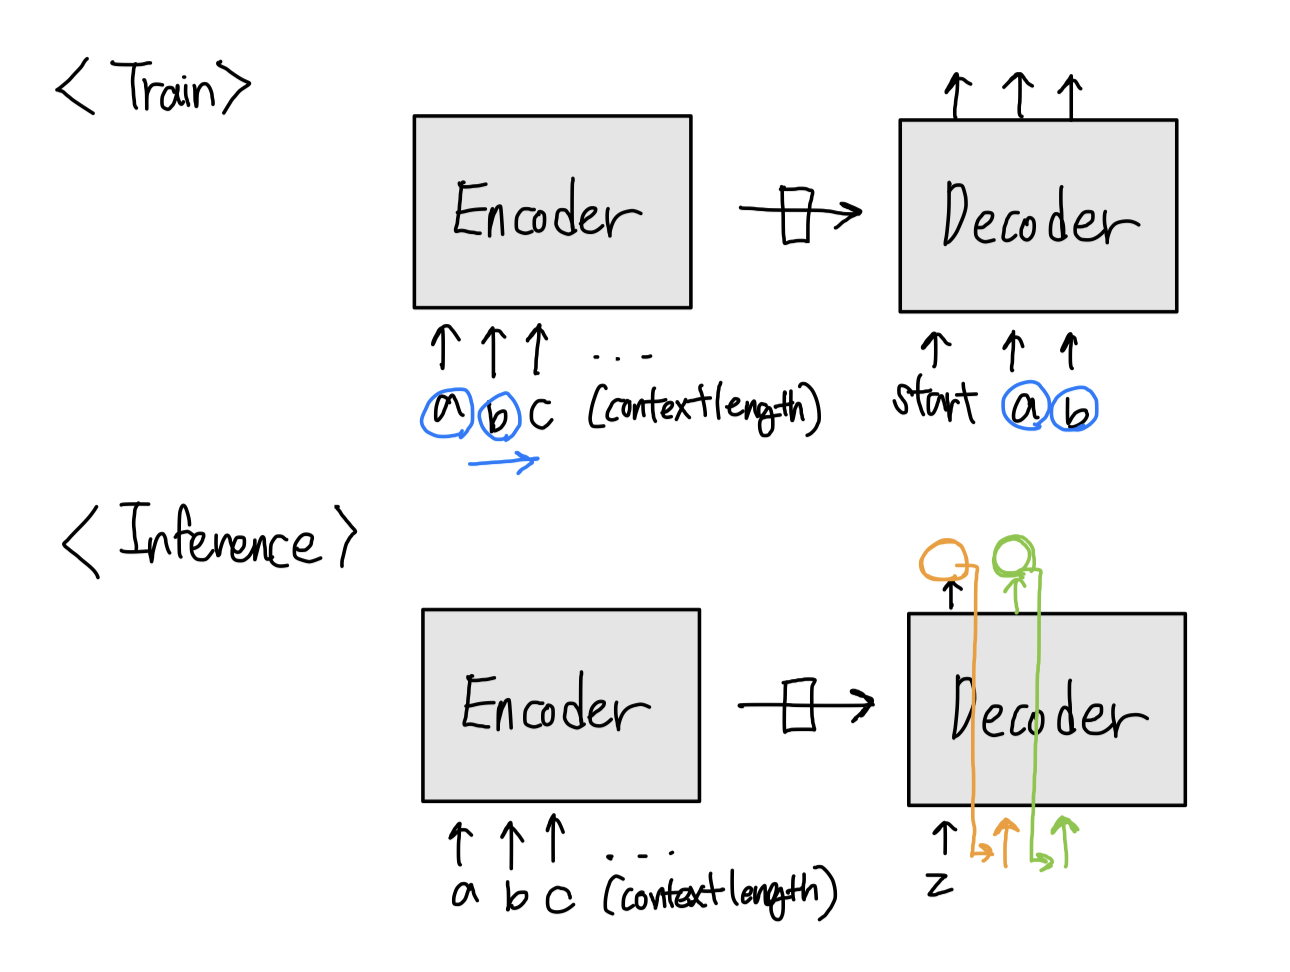![IMG_0FB4D2E3B1AE-1](https://github.com/YeoJiSu/YeoJiSu/assets/76769044/1f390b35-efe8-4084-9769-35f817ef0099)


In [11]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerModel, TimeSeriesTransformerForPrediction
from huggingface_hub import hf_hub_download
import torch
import plotly.graph_objs as go
import plotly.offline as pyo
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [1]:
# 예측을 위해 12개의 타임 스텝을 설정한 Time Series Transformer 구성 초기화
configuration = TimeSeriesTransformerConfig(prediction_length=12)

# 설정을 기반으로 랜덤하게 초기화된 모델 생성
model = TimeSeriesTransformerModel(configuration)

# 모델 설정
configuration = model.config

In [8]:
# 훈련할 데이터 다운로드 및 로드
file = hf_hub_download(
    repo_id="hf-internal-testing/tourism-monthly-batch", filename="train-batch.pt", repo_type="dataset"
)
batch = torch.load(file)

# 사전 훈련된 TimeSeriesTransformerModel 모델 불러오기
model = TimeSeriesTransformerModel.from_pretrained("huggingface/time-series-transformer-tourism-monthly")

# Training 시에는 past and future values를 제공함.
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"],
    static_real_features=batch["static_real_features"],
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
)

last_hidden_state = outputs.last_hidden_state

In [9]:
# 마지막 은닉 상태 가져오기
last_hidden_state = outputs.last_hidden_state.detach().numpy()

# 시각화를 위한 데이터 준비
# 여기서는 첫 번째 시계열 데이터의 은닉 상태를 시각화
hidden_state_1st_sequence = last_hidden_state[0]  # shape: (sequence_length, hidden_size)

# 2D로 시각화하기 위해 첫 두 차원만 선택
trace = go.Heatmap(z=hidden_state_1st_sequence.T)

layout = go.Layout(
    title='Last Hidden State Heatmap',
    xaxis=dict(title='Time Step'),
    yaxis=dict(title='Hidden Units')
)

fig = go.Figure(data=[trace], layout=layout)
fig.show()

In [13]:
# 훈련할 데이터 다운로드 및 로드
file = hf_hub_download(
    repo_id="hf-internal-testing/tourism-monthly-batch", filename="train-batch.pt", repo_type="dataset"
)
batch = torch.load(file)

# 사전 훈련된 TimeSeriesTransformerForPrediction 모델 불러오기
model = TimeSeriesTransformerForPrediction.from_pretrained(
    "huggingface/time-series-transformer-tourism-monthly"
)

# Training 시에는 past and future values를 제공함.
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"],
    static_real_features=batch["static_real_features"],
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
)

loss = outputs.loss
loss.backward()

# Inference 시에는 past values만 제공함.
# the model autoregressively generates future values
outputs = model.generate(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"],
    static_real_features=batch["static_real_features"],
    future_time_features=batch["future_time_features"],
)

mean_prediction = outputs.sequences.mean(dim=1)

In [21]:
batch.keys()

# 'static_categorical_features', 'static_real_features',
# 'past_time_features', 'past_values', 'past_observed_mask',
# 'future_time_features', 'future_values', 'future_observed_mask'

dict_keys(['static_categorical_features', 'static_real_features', 'past_time_features', 'past_values', 'past_observed_mask', 'future_time_features', 'future_values', 'future_observed_mask'])

In [6]:
# 예측값의 평균을 계산
mean_prediction = outputs.sequences.mean(dim=1).detach().numpy()

# 실제 값과 예측 값 준비
past_values = batch["past_values"].detach().numpy()
future_values = batch["future_values"].detach().numpy()

# 시계열 그래프 생성
trace1 = go.Scatter(
    x=list(range(len(past_values[0]))),  # 과거 값의 인덱스
    y=past_values[0],  # 첫 번째 시계열의 과거 값
    mode='lines',
    name='Past Values'
)

trace2 = go.Scatter(
    x=list(range(len(past_values[0]), len(past_values[0]) + len(future_values[0]))),  # 미래 값의 인덱스
    y=future_values[0],  # 첫 번째 시계열의 실제 미래 값
    mode='lines',
    name='Actual Future Values'
)

trace3 = go.Scatter(
    x=list(range(len(past_values[0]), len(past_values[0]) + len(mean_prediction[0]))),  # 예측 값의 인덱스
    y=mean_prediction[0],  # 첫 번째 시계열의 예측 값
    mode='lines',
    name='Predicted Future Values'
)

data = [trace1, trace2, trace3]

layout = go.Layout(
    title='Time Series Prediction',
    xaxis=dict(title='Time'),
    yaxis=dict(title='Values')
)

fig = go.Figure(data=data, layout=layout)
fig.show()
# 그래프를 HTML 파일로 저장 및 브라우저에서 열기
pyo.plot(fig, filename='time_series_prediction.html')

'time_series_prediction.html'

In [12]:
# 성능 지표 계산
mae = mean_absolute_error(future_values.flatten(), mean_prediction.flatten())
mse = mean_squared_error(future_values.flatten(), mean_prediction.flatten())
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 1852.82080078125
Mean Squared Error (MSE): 30540534.0
Root Mean Squared Error (RMSE): 5526.34912109375
